In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from print_color import print
import wandb
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')
from tqdm import trange

# Preprocessing

In [2]:
df = pd.read_csv('data/chessDataFinal.csv')[:1000000]
df

,fen,score
0,5rk1/pb1pnppp/3Q2q1/b3P3/2B5/5N2/P4PPP/R4RK1 w...,+276
1,b1r5/3nk2p/R7/4p1p1/1PN1P3/2BP4/7P/6K1 w - - 8 59,+451
2,5k2/5p2/3p2p1/2p4q/p1P5/P3P2K/5QP1/3R4 w - - 1 34,-317
3,r5k1/pp2qrpp/4Pp2/2bp4/2p2P2/2Q5/PP4KP/nNB1R3 ...,-594
4,2nk3r/2p3pp/3p1p2/P2Q4/3P4/q4N2/4RKP1/8 w - - ...,+281
...,...,...
999995,2r1k3/1p3pb1/p5R1/7p/4PN1P/B4P2/1Pr3P1/5K2 w -...,+512
999996,rnbqkb1r/pp3ppp/3ppn2/2p5/4P3/2NP2P1/PPP2P1P/R...,+53
999997,3r3k/1b1r3p/p4pp1/1pqnp3/4B3/1QPR1N2/5PPP/3R2K...,-413
999998,4r1k1/R7/5Q2/1p4pp/5N2/1P5P/1P4PK/4r3 b - - 2 41,#+5


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for i in trange(len(df['fen'])):
    encoded_fen = encoder_object.encode_fen(df['fen'][i])
    fen_encodings.append(encoded_fen)

100%|██████████| 1000000/1000000 [00:20<00:00, 48461.82it/s]


In [5]:
X_train = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y_train = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X_train.shape, y_train.shape

(torch.Size([1000000, 200]), torch.Size([1000000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 0

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X_train[:val_split].to(device)
y_val = y_train[:val_split].to(device)
X_test = X_train[val_split:val_split+test_split].to(device)
y_test = y_train[val_split:val_split+test_split].to(device)
X_train = X_train[val_split+test_split:]
y_train = y_train[val_split+test_split:]

# Training

In [12]:
# hyperparameters
lr = 5e-2
num_steps = 5000
warmup_steps = 300
bs_train = 10000
bs_validation = len(X_val) # don't change this
if bs_train > len(X_train): bs_train = len(X_train)
# if bs_validation > len(X_train): bs_validation = len(X_train)
enable_live_monitoring = False
embedding_dim = 32
weight_decay = 1e-2

In [13]:
len(X_train), len(X_val)

(990000, 10000)

In [14]:
model = MLPEngine(embedding_dim=embedding_dim, bs_train = bs_train, bs_eval=bs_validation).to(device)
loss_category = nn.MSELoss()

# from torch.nn import SmoothL1Loss
# loss_category = SmoothL1Loss()

optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=weight_decay)

# Trapezoidal scheduler
def lr_lambda(epoch):
    if epoch < warmup_steps:
        return epoch / warmup_steps
    elif epoch < num_steps // 2:
        return 1.0
    else:
        return max(0.1, (num_steps - epoch) / (num_steps // 2))
scheduler = LambdaLR(optimiser, lr_lambda)

# Exponential scheduler
# def lr_lambda(epoch):
#     if epoch < warmup_steps:  
#         return epoch / warmup_steps
#     else:  # Exponential decay after warm-up
#         return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model.compile()
train_history = {}
val_history = {}
start_step = 0

In [15]:
if enable_live_monitoring:
    run = wandb.init(project="chessAI")
    wandb.watch(model)

In [16]:
model.train()
for step_i in range(1, num_steps+1):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X_train, y_train, bs_train) 
    # print(x_batch.shape, y_batch.shape)
    y_pred = model(x_batch).view(bs_train)
    loss = loss_category(y_pred, y_batch)
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    if enable_live_monitoring: wandb.log({"Training Loss": loss.item()})
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0 or tot_step==1:
        # validation phase
        model.eval()
        y_pred = model(X_val).view(bs_validation)
        # print(X_val.shape, y_pred.shape)
        loss = loss_category(y_pred, y_val)
        val_history[tot_step] = loss.item()
        print(f'{tot_step}: {loss.item()} (Validation)', color='r')
        if enable_live_monitoring: wandb.log({"Validation Loss": loss.item()})
        model.train()


start_step += num_steps

1 :  3654033.75
1: 3450039.0 (Validation)
2 :  3613914.25
3 :  3639010.5
4 :  3729380.0
5 :  3728241.25
6 :  3849911.75
7 :  3617061.25
8 :  3702751.25
9 :  3873966.75
10 :  3952481.75
11 :  3566600.0
12 :  3532082.0
13 :  4027090.5
14 :  3718097.25
15 :  3491192.75
16 :  3496735.0
17 :  3559393.5
18 :  3916226.75
19 :  3576238.5
20 :  3482031.75
21 :  3527378.75
22 :  3866804.5
23 :  3549544.75
24 :  3467856.25
25 :  3901010.75
26 :  3326787.5
27 :  3398651.75
28 :  3489169.25
29 :  3812010.75
30 :  3975795.0
31 :  3235039.25
32 :  3685711.75
33 :  3547167.0
34 :  3605488.75
35 :  3807653.75
36 :  4030020.75
37 :  3414941.75
38 :  3790344.0
39 :  3476686.75
40 :  3544863.5
41 :  3436075.25
42 :  3719619.25
43 :  3658217.75
44 :  3581616.75
45 :  3679258.0
46 :  3228520.75
47 :  3590431.75
48 :  3670339.0
49 :  3715583.5
50 :  3798836.75
51 :  3602864.5
52 :  3262341.5
53 :  3569812.5
54 :  3605894.25
55 :  3392814.75
56 :  3795168.25
57 :  3386694.5
58 :  3494498.75
59 :  3757862.75
6

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'saves/model3.pt')

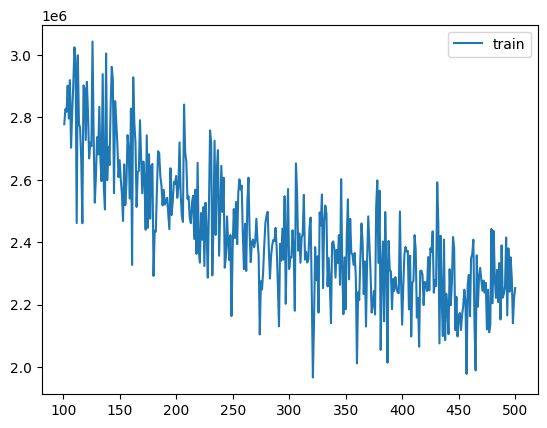

In [ ]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

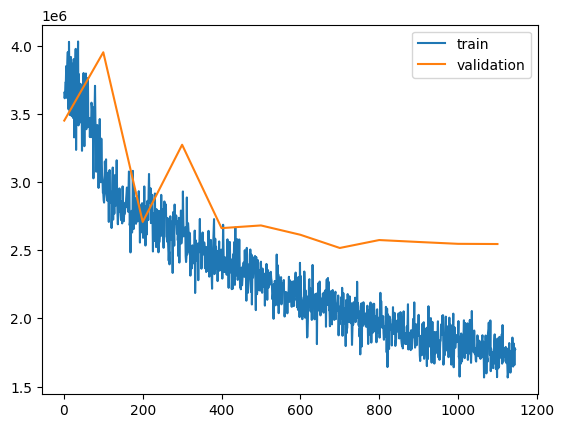

In [17]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [x] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [x] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note

My model is overfitting. What can i do?
- potential bug in val loss calculation
- regualisation
  - dropout
  - l1, l2
- make the model smaller, length and breadth
- 
- increase dataset, increase variety